In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import itertools
from os import listdir
import uproot
import awkward as ak
from sklearn.model_selection import train_test_split

import matplotlib as mpl

from datetime import datetime
import subprocess
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential
import os
import tensorflow as tf
import sys
import importlib
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
from omnifold import DataLoader, MLP, SetStyle, HistRoutine, net, PET, omnifold
import test_omnifold
from of_transformer import block, embed, input_distributed, net_utils, of_transformer, pair_embed, sequence_trimmer 
import PET

from IPython.display import Image

os.environ['CUDA_VISIBLE_DEVICES']="6" # GPU Server Available: 0,1,2,3,4,5,6,7
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="3"
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

2025-10-27 08:18:04.569531: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-27 08:18:05.271160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761549485.489249  129414 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761549485.540462  129414 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761549486.086416  129414 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Horovod not found, will continue with single only GPUs.
Horovod not found, will continue with single only GPUs.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
pythia_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_ttbar.pkl')
herwig_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_herwig_ttbar.pkl')

def MC_data_shaper(df):

    particle_names = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6']

    # Build reco and truth arrays
    reco_pts  = [df[f'pt{p}']   for p in particle_names]
    reco_etas = [df[f'eta{p}']  for p in particle_names]
    reco_phis = [df[f'phi{p}']  for p in particle_names]
    
    # Masses: lepton = 0, b-jets = mb1–4, jets = mj1–6
    reco_masses = [np.zeros_like(df['ptl1'])] + \
                  [df[f'mb{i}'] for i in range(1, 5)] + \
                  [df[f'mj{i}'] for i in range(1, 7)]
    # Stack into (12 particles, n_events, 4)
    reco_features = np.stack([reco_pts, reco_etas, reco_phis, reco_masses], axis=-1)
    reco_features = reco_features.transpose(1, 0, 2)  # → (n_events, 12, 4)

    # Neutrino (reco): met, eta=0, phi=metphi, mass=0
    met_pt = df['met']
    met_phi = df['metphi']
    zeros = np.zeros_like(met_pt)
    neutrino_reco = np.stack([met_pt, zeros, met_phi, zeros], axis=-1)  # (n_events, 4)

    # Append neutrino
    reco_features = np.concatenate([reco_features, neutrino_reco[:, None, :]], axis=1)  # (n_events, 12, 4)
    truth_pts  = [df[f'truth_pt{p}']   for p in particle_names]
    truth_etas = [df[f'truth_eta{p}']  for p in particle_names]
    truth_phis = [df[f'truth_phi{p}']  for p in particle_names]
    
    truth_masses = [np.zeros_like(df['truth_ptl1'])] + \
                   [df[f'truth_mb{i}'] for i in range(1, 5)] + \
                   [df[f'truth_mj{i}'] for i in range(1, 7)]

    truth_features = np.stack([truth_pts, truth_etas, truth_phis, truth_masses], axis=-1)
    truth_features = truth_features.transpose(1, 0, 2)

    # Neutrino (truth): use 'truth_met' and 'truth_met_phi'
    truth_met_pt = df['truth_met']
    truth_met_phi = df['truth_metphi']
    zeros_truth = np.zeros_like(truth_met_pt)
    neutrino_truth = np.stack([truth_met_pt, zeros_truth, truth_met_phi, zeros_truth], axis=-1)

    truth_features = np.concatenate([truth_features, neutrino_truth[:, None, :]], axis=1)
    
    return reco_features, truth_features

pythia_reco, pythia_truth = MC_data_shaper(pythia_df)
herwig_reco, herwig_truth = MC_data_shaper(herwig_df)

pythia_weights = pythia_df['eventWeight'].to_numpy()
herwig_weights = herwig_df['eventWeight'].to_numpy()

pythia_pass_reco = pythia_df['pass_reco'].to_numpy()
pythia_pass_gen = pythia_df['pass_particle'].to_numpy()

herwig_pass_reco = herwig_df['pass_reco'].to_numpy()
herwig_pass_gen = herwig_df['pass_particle'].to_numpy()

In [3]:
def convert_to4vector(array):
    """
    Convert an array of shape (n_events, n_particles, 4) with (pt, eta, phi, m)
    to an array of shape (n_events, n_particles, 4) with (E, px, py, pz).
    """
    pt = array[:, 0]
    eta = array[:, 1]
    phi = array[:, 2]
    m = array[:, 3]

    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    E = np.sqrt(px**2 + py**2 + pz**2 + m**2)

    return np.stack((E, px, py, pz), axis=-1)

def calculate_mass(array):
    """
    Calculate the invariant mass of the system represented by the input array.
    The input array should have shape (n_events, n_particles, 4) with (E, px, py, pz).
    Returns an array of shape (n_events,) with the invariant mass for each event.
    """
    E = array[:, 0]
    px = array[:, 1]
    py = array[:, 2]
    pz = array[:, 3]

    mass_squared = E**2 - (px**2 + py**2 + pz**2)
    mass_squared = np.maximum(mass_squared, 0)  # Avoid negative values due to numerical issues
    return np.sqrt(mass_squared)

def W_candidate(array):
    # Hard coded W mass
    W_mass = 80.379

    # leading and subleading jets (indices 5 and 6)
    leading_jet = array[:, 5, :]
    subleading_jet = array[:, 6, :]
    leading_jet_4vec = convert_to4vector(leading_jet)
    subleading_jet_4vec = convert_to4vector(subleading_jet)
    combined_4vec = leading_jet_4vec + subleading_jet_4vec

    # Calculate masses
    mass_leading = calculate_mass(leading_jet_4vec)
    mass_subleading = calculate_mass(subleading_jet_4vec)
    mass_combined = calculate_mass(combined_4vec)

    # Stack all masses and 4-vectors: shape (n_events, 3)
    all_masses = np.stack([mass_leading, mass_subleading, mass_combined], axis=1)
    all_4vecs = np.stack([leading_jet_4vec, subleading_jet_4vec, combined_4vec], axis=1)

    # Find index of mass closest to W_mass for each event
    idx_closest = np.argmin(np.abs(all_masses - W_mass), axis=1)

    # Select 4-vector for each event
    selected_4vec = all_4vecs[np.arange(len(array)), idx_closest, :]

    return selected_4vec

def min_mbl(array):
    # b-jet indices: 1, 2
    b_jets = [array[:, i, :] for i in range(1,3)]
    lepton = array[:, 0, :]

    b_jet_4vecs = [convert_to4vector(b_jet) for b_jet in b_jets]
    lepton_4vec = convert_to4vector(lepton)

    mbl_values = []
    for b_jet_4vec in b_jet_4vecs:
        combined_4vec = b_jet_4vec + lepton_4vec
        mbl = calculate_mass(combined_4vec)
        mbl_values.append(mbl)

    mbl_stack = np.stack(mbl_values, axis=1)  # shape (n_events, 2)
    return np.min(mbl_stack, axis=1)  # shape (n_events,)

def min_mbW(array):
    # b-jet indices: 1, 2
    b_jet1 = array[:, 1, :]
    b_jet2 = array[:, 2, :]

    b_jet1_4vec = convert_to4vector(b_jet1)
    b_jet2_4vec = convert_to4vector(b_jet2)

    W_4vec = W_candidate(array)

    combined1_4vec = b_jet1_4vec + W_4vec
    combined2_4vec = b_jet2_4vec + W_4vec

    mbW1 = calculate_mass(combined1_4vec)
    mbW2 = calculate_mass(combined2_4vec)

    mbW_stack = np.stack([mbW1, mbW2], axis=1)  # shape (n_events, 2)
    return np.min(mbW_stack, axis=1)  # shape (n_events,)


def mbb(array):
    # b-jet indices: 1, 2
    b_jet1 = array[:, 1, :]
    b_jet2 = array[:, 2, :]

    b_jet1_4vec = convert_to4vector(b_jet1)
    b_jet2_4vec = convert_to4vector(b_jet2)

    combined_4vec = b_jet1_4vec + b_jet2_4vec
    return calculate_mass(combined_4vec)

def dR2b(array):
    # b-jet indices: 1, 2
    b_jet1 = array[:, 1, :]
    b_jet2 = array[:, 2, :]

    eta1 = b_jet1[:, 1]
    phi1 = b_jet1[:, 2]
    eta2 = b_jet2[:, 1]
    phi2 = b_jet2[:, 2]

    delta_eta = eta1 - eta2
    delta_phi = np.abs(phi1 - phi2)
    delta_phi = np.where(delta_phi > np.pi, 2 * np.pi - delta_phi, delta_phi)

    return np.sqrt(delta_eta**2 + delta_phi**2)

# OmniFold example using high-level features as inputs

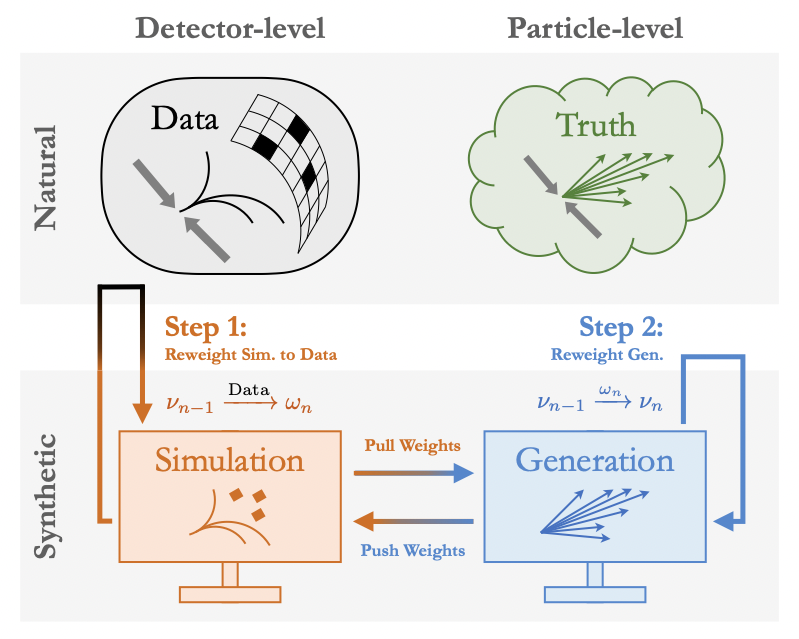

In [3]:
Image(filename='Omnifold.png')

In [4]:
pythia_MC_gen = min_mbl(pythia_truth)
pythia_MC_reco = min_mbl(pythia_reco)

herwig_MC_gen = min_mbl(herwig_truth)
herwig_MC_reco = min_mbl(herwig_reco)

In [5]:
all_indices_pythia = np.arange(len(pythia_reco))
np.random.seed(42)  # reproducibility
np.random.shuffle(all_indices_pythia)

# First random sample
random_indices_pythia_1 = all_indices_pythia[:1_000_000]
# Second, independent (non-overlapping) sample
random_indices_pythia_2 = all_indices_pythia[1_000_000:2_000_000]

# First Pythia sample
pythia_reco_train    = pythia_MC_reco[random_indices_pythia_1]
pythia_truth_train   = pythia_MC_gen[random_indices_pythia_1]
pythia_weights_train = pythia_weights[random_indices_pythia_1]
pythia_pass_reco_train = pythia_pass_reco[random_indices_pythia_1]
pythia_pass_gen_train = pythia_pass_gen[random_indices_pythia_1]

# Second Pythia sample
pythia_reco_test    = pythia_MC_reco[random_indices_pythia_2]
pythia_truth_test   = pythia_MC_gen[random_indices_pythia_2]
pythia_weights_test = pythia_weights[random_indices_pythia_2]
pythia_pass_reco_test = pythia_pass_reco[random_indices_pythia_2]
pythia_pass_gen_test = pythia_pass_gen[random_indices_pythia_2]

all_indices_herwig = np.arange(len(herwig_reco))
np.random.seed(42)  # reproducibility
np.random.shuffle(all_indices_herwig)

# First random sample
random_indices_herwig_1 = all_indices_herwig[:1_000_000]
# Second, independent (non-overlapping) sample
random_indices_herwig_2 = all_indices_herwig[1_000_000:2_000_000]

# First Pythia sample
herwig_reco_train    = herwig_MC_reco[random_indices_herwig_1]
herwig_truth_train   = herwig_MC_gen[random_indices_herwig_1]
herwig_weights_train = herwig_weights[random_indices_herwig_1]
herwig_pass_reco_train = herwig_pass_reco[random_indices_herwig_1]
herwig_pass_gen_train = herwig_pass_gen[random_indices_herwig_1]

# Second Pythia sample
herwig_reco_test    = herwig_MC_reco[random_indices_herwig_2]
herwig_truth_test   = herwig_MC_gen[random_indices_herwig_2]
herwig_weights_test = herwig_weights[random_indices_herwig_2]
herwig_pass_reco_test = herwig_pass_reco[random_indices_herwig_2]
herwig_pass_gen_test = herwig_pass_gen[random_indices_herwig_2]

In [6]:
herwig_loader = DataLoader(reco = herwig_reco_train, gen = herwig_truth_train, weight = herwig_weights_train,
                           pass_reco = herwig_pass_reco_train, pass_gen = herwig_pass_gen_train,
                           normalize=True, normalization_factor = np.sum(herwig_weights_train))

pythia_loader = DataLoader(reco = pythia_reco_train, gen = pythia_truth_train, weight = pythia_weights_train,
                           pass_reco = pythia_pass_reco_train, pass_gen = pythia_pass_gen_train,
                           normalize=True, normalization_factor = np.sum(pythia_weights_train))


#data = DataLoader(reco = reco_data,normalize=True)
#mc = DataLoader(reco = reco_mc,gen = gen_mc,normalize=True)

INFO: Normalizing sum of weights to 172446.84375 ...
INFO: Normalizing sum of weights to 58135.8984375 ...


## Let's take a quick look at the data

(<Figure size 900x900 with 2 Axes>,
 <Axes: ylabel='Normalized number of events'>)

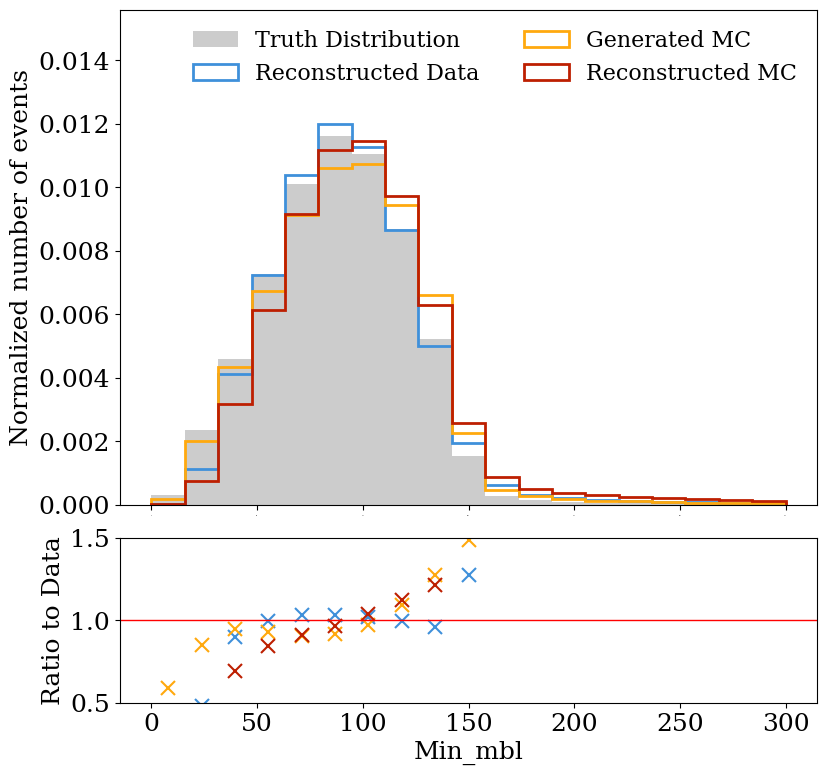

In [26]:
SetStyle()
data_dict = {
    'Truth Distribution': herwig_loader.gen[herwig_loader.pass_gen],
    'Reconstructed Data': herwig_loader.reco[herwig_loader.pass_reco],
    'Generated MC': pythia_loader.gen[pythia_loader.pass_gen],
    'Reconstructed MC': pythia_loader.reco[pythia_loader.pass_reco],
}
HistRoutine(data_dict,'Min_mbl', reference_name = 'Truth Distribution',plot_ratio=True, binning = np.linspace(0,300,20),)

## Let's now create the neural network models we are going to use to model the weight distributions

In [10]:
model1 = MLP(1)
model2 = MLP(1)

I0000 00:00:1761294288.673598 2363579 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 123233 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:c3:00.0, compute capability: 9.0


In [11]:
print(model1.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 0 (0.00 B)

None


## Let's now unfold!

In [ ]:
omnifold = test_omnifold.MultiFold(
    "original_test_mlb",
    model1,
    model2,
    herwig_loader,
    pythia_loader,
    batch_size = 512,
    niter = 5,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = 'weights_original_test_mlb',
    verbose = True,
    lr = 5e-5,
)

3906 training steps at reco and 3906 steps at gen


In [13]:
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 1999872, Test events used: 399974
################################################################################
Epoch 1/100


I0000 00:00:1761294298.693165 2644269 service.cc:152] XLA service 0x7f2514003e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761294298.693208 2644269 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2025-10-24 10:24:58.796512: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761294299.149830 2644269 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1761294300.217665 2644269 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3124/3124 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0235 - val_loss: 0.0231 - learning_rate: 5.0000e-05
Epoch 2/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0232 - val_loss: 0.0232 - learning_rate: 5.0000e-05
Epoch 3/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0233 - val_loss: 0.0231 - learning_rate: 5.0000e-05
Epoch 4/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0232 - val_loss: 0.0232 - learning_rate: 5.0000e-05
Epoch 5/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0231 - val_loss: 0.0231 - learning_rate: 5.0000e-05
Epoch 6/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0231 - val_loss: 0.0231 - learning_rate: 5.0000e-05
Epoch 7/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0232 - val_loss: 0.0231 - learning_rate: 5.0000e-05
Epoch 8/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0232 - val_loss: 0.0232 - learning_rate: 5.0000e-05
Epoch 9/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.02

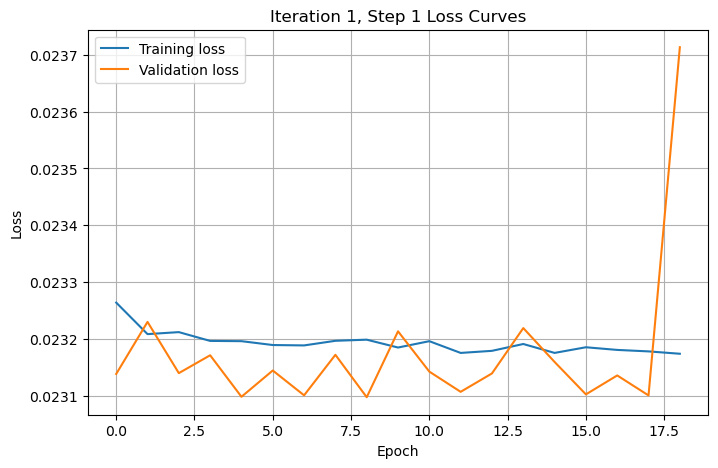

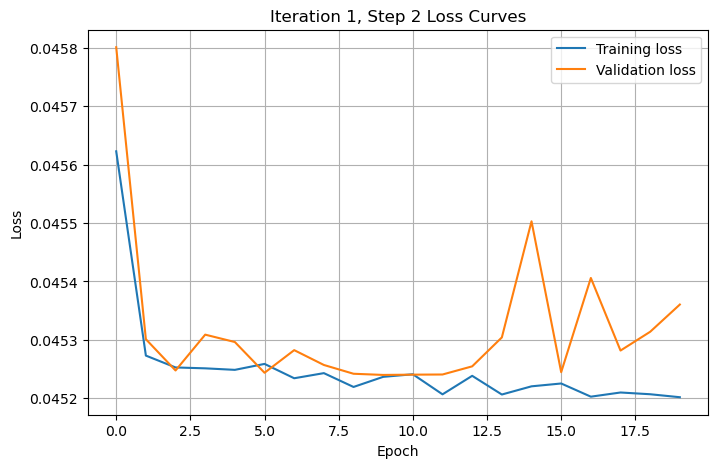

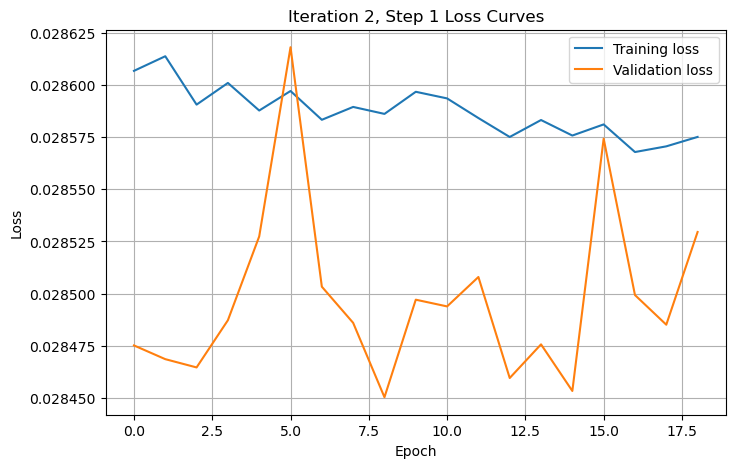

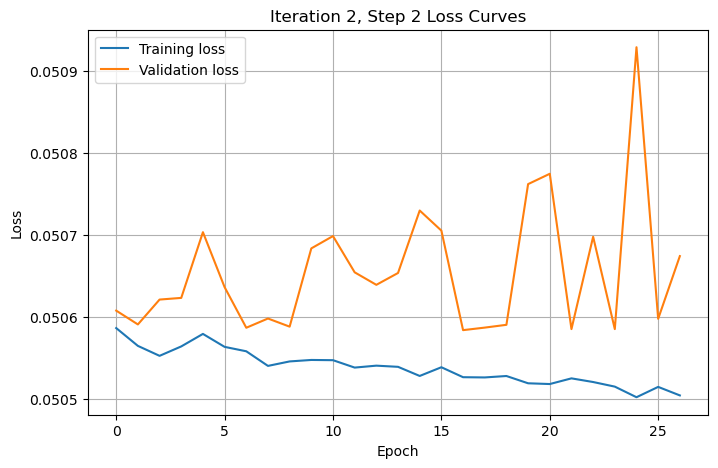

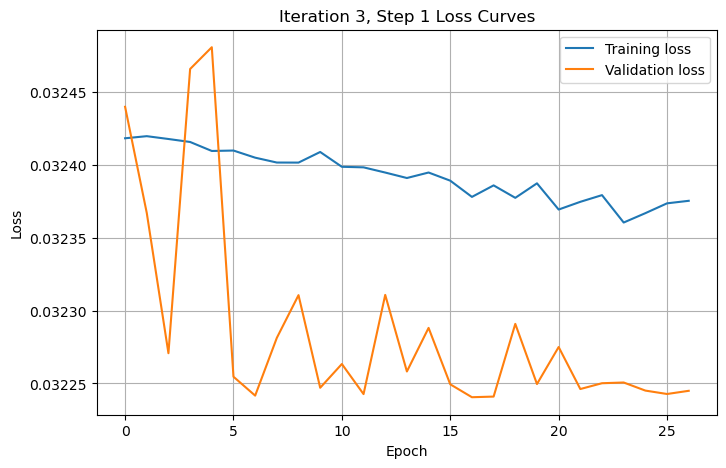

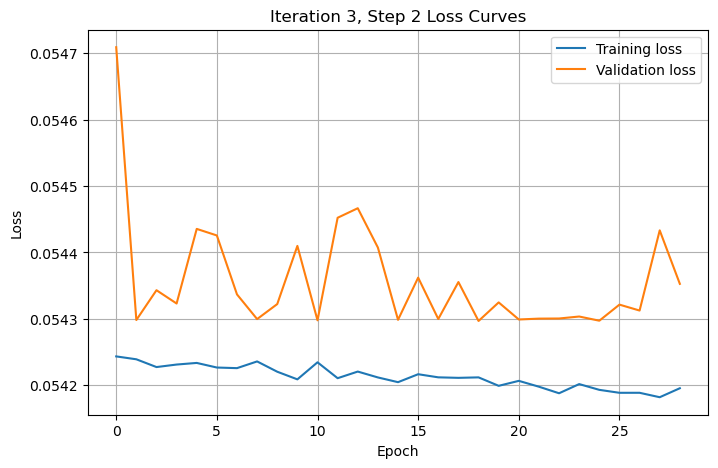

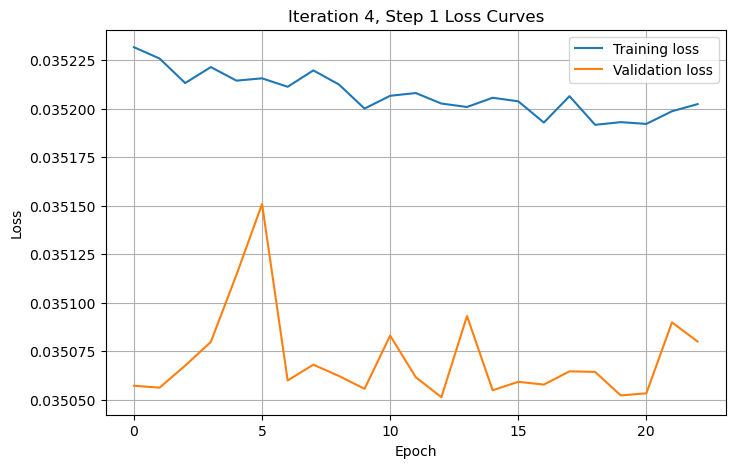

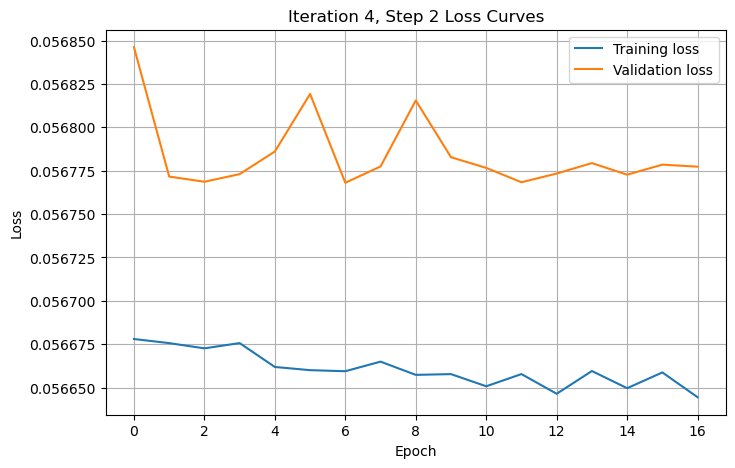

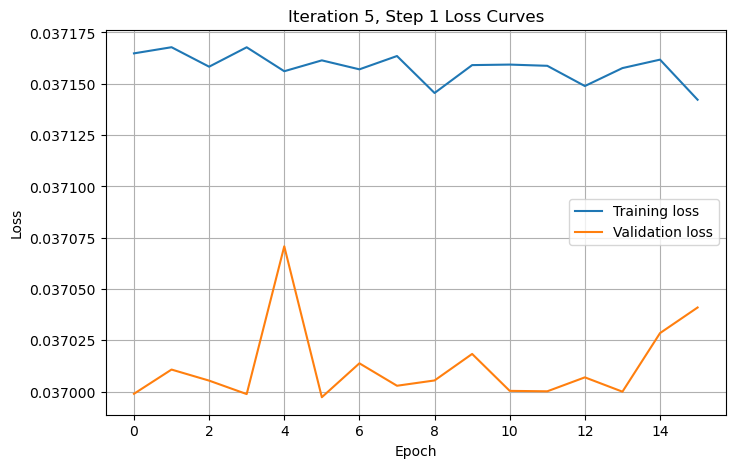

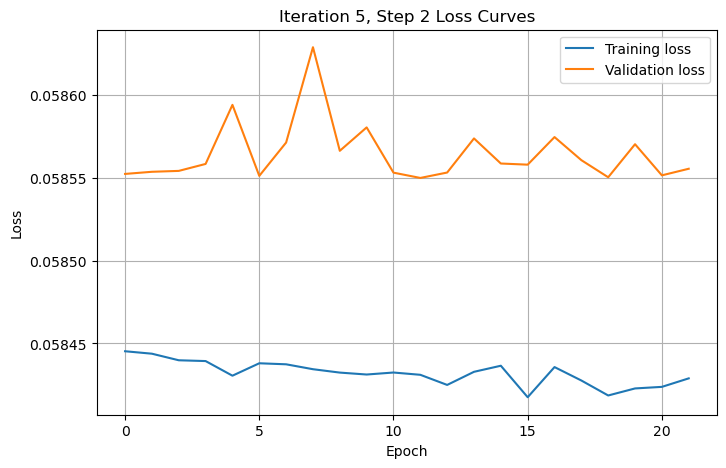

In [2]:
import pickle
import os
# Set these to your parameters
weights_folder = 'weights_original_test_mlb'      
name = "original_test_mlb"     
niter = 5                       
n_ensemble = 1                  
# Loop over iterations and steps
for iteration in range(niter):
    for stepn in [1, 2]:
        plt.figure(figsize=(8,5))
        plt.title(f"Iteration {iteration+1}, Step {stepn} Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        all_loss = []
        all_val_loss = []

        for e in range(n_ensemble):
            # Construct pickle file name
            model_file = f"{weights_folder}/OmniFold_{name}_iter{iteration}_step{stepn}"
            if n_ensemble > 1:
                model_file += f"_ensemble{e}"
            model_file += ".weights.h5"
            history_file = model_file.replace(".weights.h5", ".pkl")
            
            # Load history
            if os.path.exists(history_file):
                with open(history_file, "rb") as f:
                    history = pickle.load(f)
                all_loss.append(history['loss'])
                all_val_loss.append(history['val_loss'])
            else:
                print(f"History file not found: {history_file}")

        # Average over ensembles if multiple
        avg_loss = np.mean(all_loss, axis=0)
        avg_val_loss = np.mean(all_val_loss, axis=0)

        plt.plot(avg_loss, label='Training loss')
        plt.plot(avg_val_loss, label='Validation loss')
        plt.legend()
        plt.grid(True)
        plt.show()


## Now, let's evaluate the model!

In [14]:
validation_data = pythia_truth_test
unfolded_weights  = omnifold.reweight(validation_data,omnifold.model2,batch_size=1000)   

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [21]:
print(unfolded_weights.shape, (validation_data*pythia_pass_gen_test).shape)

(1000000,) (1000000,)


## More plots!

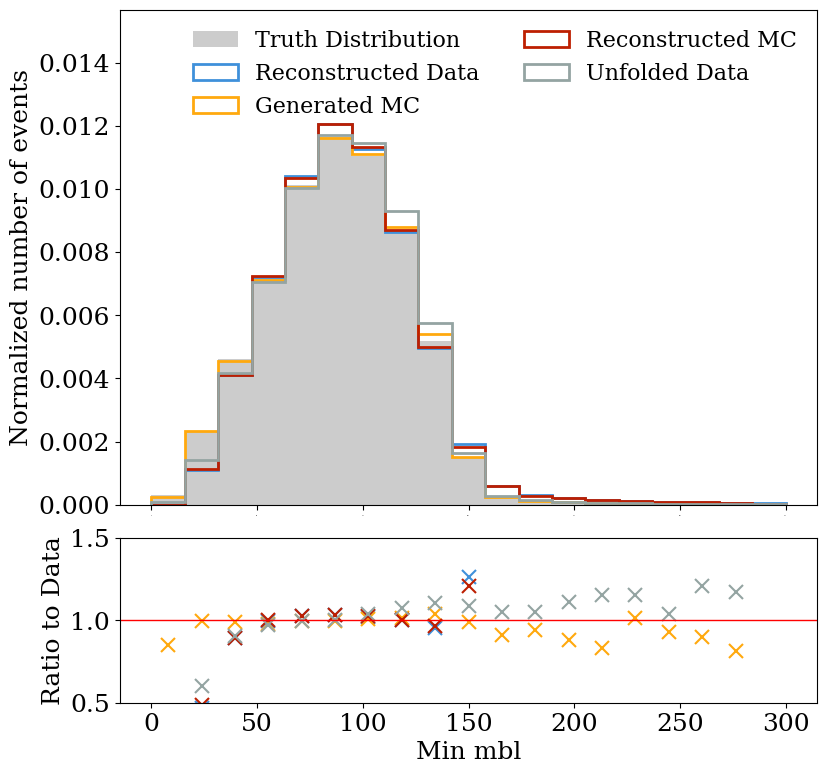

In [29]:
data_dict = {
    'Truth Distribution': herwig_loader.gen[herwig_loader.pass_gen],
    'Reconstructed Data': herwig_loader.reco[herwig_loader.pass_reco],
    'Generated MC': pythia_loader.gen[pythia_loader.pass_gen],
    'Reconstructed MC': pythia_loader.reco[pythia_loader.pass_reco],
    'Unfolded Data': validation_data*pythia_pass_gen_test,
}

weight_dict = {
    'Truth Distribution': herwig_loader.weight[herwig_loader.pass_gen],
    'Reconstructed Data': herwig_loader.weight[herwig_loader.pass_reco],
    'Generated MC': pythia_loader.weight[pythia_loader.pass_gen],
    'Reconstructed MC': pythia_loader.weight[pythia_loader.pass_reco],
    'Unfolded Data': unfolded_weights*pythia_weights_test*pythia_pass_gen_test,
    }

fig,_ = HistRoutine(data_dict,'Min mbl',
                    reference_name = 'Truth Distribution',
                    weights = weight_dict,
                    plot_ratio = True,
                    binning = np.linspace(0,300,20)
                    )
